In [11]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [1]:
trials = pd.read_csv("clinical_trials_cleaned.csv")

In [2]:
trials.head()

,status,phase,sex,age,nct number,inclusion,exclusion,enrollment,min_age,max_age,inclusion_clean,exclusion_clean
0,"Active, not recruiting",Not Applicable,all,"18 Years and older (Adult, Older Adult)",NCT04321421,death [ Time Frame: within 7 days ]death from ...,time to extubation [ Time Frame: within 7 days...,49.0,18,120,death time frame within 7 days death from any...,time to extubation time frame within 7 days d...
1,Not yet recruiting,Phase 2\nPhase 3,all,"18 Years to 75 Years (Adult, Older Adult)",NCT04291053,Mortality rate [ Time Frame: up to 28 days ]Al...,Clinical status assessed according to the offi...,550.0,18,120,mortality rate time frame up to 28 days all c...,clinical status assessed according to the offi...
2,Recruiting,Not Applicable,all,"18 Years to 70 Years (Adult, Older Adult)",NCT04324489,Improved clinical status [ Time Frame: Day 14 ...,SARS-CoV-2 RNA [ Time Frame: 28 days ]time to ...,4.0,18,120,improved clinical status time frame day 14 pe...,sarscov2 rna time frame 28 days time to sarsc...
3,Not yet recruiting,Phase 4,all,"18 Years to 65 Years (Adult, Older Adult)",NCT04323228,Change from baseline score of Nutrition risk s...,Change from baseline Weight at end of the tria...,30.0,18,120,change from baseline score of nutrition risk s...,change from baseline weight at end of the tria...
4,Withdrawn,Not Applicable,all,"18 Years to 80 Years (Adult, Older Adult)",NCT04287686,Time course of body temperature (fever) [ Time...,P/F ratio over time [ Time Frame: 14 days ]PaO...,0.0,18,120,time course of body temperature fever time fr...,pf ratio over time time frame 14 days pao2fio...


In [3]:
trials["inclusion_clean"] = (
    trials["inclusion_clean"]
    .astype(str)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

trials["exclusion_clean"] = (
    trials["exclusion_clean"]
    .astype(str)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

In [4]:
trials["eligibility_text"] = (
    "inclusion criteria: " + trials["inclusion_clean"] +
    " exclusion criteria: " + trials["exclusion_clean"]
)

In [5]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def preprocess_for_keywords(text):
    tokens = text.split()
    tokens = [t for t in tokens if t not in ENGLISH_STOP_WORDS]
    return " ".join(tokens)

trials["eligibility_keywords"] = (
    trials["eligibility_text"]
    .apply(preprocess_for_keywords)
)

In [6]:
trials["sex"] = trials["sex"].str.lower().fillna("all")

In [7]:
trials["min_age"] = trials["min_age"].clip(0, 120)
trials["max_age"] = trials["max_age"].clip(0, 120)

In [8]:
active_status = ["recruiting", "active", "enrolling"]

trials["status"] = trials["status"].str.lower()

trials_active = trials[
    trials["status"].str.contains("|".join(active_status), na=False)
]

In [9]:
patients = pd.DataFrame([
    {
        "patient_id": 1,
        "age": 45,
        "sex": "female",
        "conditions": "covid-19",
        "medical_text": "45 year old female diagnosed with covid 19"
    },
    {
        "patient_id": 2,
        "age": 65,
        "sex": "male",
        "conditions": "covid-19 pneumonia",
        "medical_text": "65 year old male with covid 19 pneumonia"
    }
])

In [10]:
patients["sex"] = patients["sex"].str.lower()
patients["medical_text"] = patients["medical_text"].str.lower()

In [12]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2
)

tfidf_trials = vectorizer.fit_transform(
    trials["eligibility_keywords"]
)

In [13]:
tfidf_patients = vectorizer.transform(
    patients["medical_text"]
)

In [14]:
similarity_matrix = cosine_similarity(
    tfidf_patients,
    tfidf_trials
)

In [16]:
def eligibility_filter(trial, patient):
    age_ok = (
        patient["age"] >= trial["min_age"]
        and patient["age"] <= trial["max_age"]
    )
    
    sex_ok = (
        trial["sex"] == "all"
        or trial["sex"] == patient["sex"]
    )
    
    return age_ok and sex_ok

In [17]:
def rank_trials_for_patient(
    patient_idx,
    top_k=5
):
    patient = patients.iloc[patient_idx]
    scores = similarity_matrix[patient_idx]
    
    ranked_indices = np.argsort(scores)[::-1]
    
    results = []
    
    for idx in ranked_indices:
        trial = trials.iloc[idx]
        
        if eligibility_filter(trial, patient):
            results.append({
                "nct_number": trial["nct number"],
                "similarity_score": scores[idx],
                "sex": trial["sex"],
                "min_age": trial["min_age"],
                "max_age": trial["max_age"],
                "inclusion": trial["inclusion_clean"][:300]
            })
        
        if len(results) == top_k:
            break
    
    return pd.DataFrame(results)

In [18]:
rank_trials_for_patient(
    patient_idx=0,
    top_k=5
)

,nct_number,similarity_score,sex,min_age,max_age,inclusion
0,NCT04313946,0.305318,all,0,120,specifically convolutional neural networks cnn...
1,NCT04322565,0.175563,all,18,120,clinical improvement time frame day 28 time to...
2,NCT04313023,0.133455,all,18,120,prevention of covid19 time frame 14 days diffe...
3,NCT04316884,0.121695,all,18,120,acute kidney injury time frame during intensiv...
4,NCT04320732,0.119388,all,18,120,hospitalized and nonhospitalized patientsperso...


In [19]:
!pip install -q sentence-transformers

In [20]:
from sentence_transformers import SentenceTransformer

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [21]:
model = SentenceTransformer("all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [22]:
trial_embeddings = model.encode(
    trials["eligibility_text"].tolist(),
    show_progress_bar=True,
    convert_to_numpy=True
)

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [23]:
patient_embeddings = model.encode(
    patients["medical_text"].tolist(),
    convert_to_numpy=True
)

In [24]:
semantic_similarity = cosine_similarity(
    patient_embeddings,
    trial_embeddings
)

In [25]:
def eligibility_filter(trial, patient):
    age_ok = (
        patient["age"] >= trial["min_age"]
        and patient["age"] <= trial["max_age"]
    )
    
    sex_ok = (
        trial["sex"] == "all"
        or trial["sex"] == patient["sex"]
    )
    
    return age_ok and sex_ok

In [26]:
def rank_trials_semantic(
    patient_idx,
    top_k=5
):
    patient = patients.iloc[patient_idx]
    scores = semantic_similarity[patient_idx]
    
    ranked_indices = np.argsort(scores)[::-1]
    
    results = []
    
    for idx in ranked_indices:
        trial = trials.iloc[idx]
        
        if eligibility_filter(trial, patient):
            results.append({
                "nct_number": trial["nct number"],
                "semantic_score": scores[idx],
                "sex": trial["sex"],
                "min_age": trial["min_age"],
                "max_age": trial["max_age"],
                "inclusion": trial["inclusion_clean"][:300]
            })
        
        if len(results) == top_k:
            break
    
    return pd.DataFrame(results)

In [27]:
rank_trials_semantic(
    patient_idx=0,
    top_k=5
)

,nct_number,semantic_score,sex,min_age,max_age,inclusion
0,NCT04320732,0.663438,all,18,120,hospitalized and nonhospitalized patientsperso...
1,NCT04292327,0.571024,all,18,120,mortality time frame 28 day the mortality of c...
2,NCT04308668,0.564929,all,18,120,to test if postexposure prophylaxis with hydro...
3,NCT04323839,0.555498,female,18,120,clinical presentation time frame baseline to 1...
4,NCT04318444,0.543220,all,18,120,number of participants with symptomatic labcon...


In [28]:
def compare_models(patient_idx, top_k=5):
    baseline = rank_trials_for_patient(patient_idx, top_k)
    semantic = rank_trials_semantic(patient_idx, top_k)
    
    baseline["model"] = "TF-IDF"
    semantic["model"] = "Sentence-BERT"
    
    return pd.concat([baseline, semantic], ignore_index=True)

In [29]:
compare_models(patient_idx=0, top_k=5)

,nct_number,similarity_score,sex,min_age,max_age,inclusion,model,semantic_score
0,NCT04313946,0.305318,all,0,120,specifically convolutional neural networks cnn...,TF-IDF,NaN
1,NCT04322565,0.175563,all,18,120,clinical improvement time frame day 28 time to...,TF-IDF,NaN
2,NCT04313023,0.133455,all,18,120,prevention of covid19 time frame 14 days diffe...,TF-IDF,NaN
3,NCT04316884,0.121695,all,18,120,acute kidney injury time frame during intensiv...,TF-IDF,NaN
4,NCT04320732,0.119388,all,18,120,hospitalized and nonhospitalized patientsperso...,TF-IDF,NaN
5,NCT04320732,NaN,all,18,120,hospitalized and nonhospitalized patientsperso...,Sentence-BERT,0.663438
6,NCT04292327,NaN,all,18,120,mortality time frame 28 day the mortality of c...,Sentence-BERT,0.571024
7,NCT04308668,NaN,all,18,120,to test if postexposure prophylaxis with hydro...,Sentence-BERT,0.564929
8,NCT04323839,NaN,female,18,120,clinical presentation time frame baseline to 1...,Sentence-BERT,0.555498
9,NCT04318444,NaN,all,18,120,number of participants with symptomatic labcon...,Sentence-BERT,0.543220


In [30]:
def explain_recommendation(trial, patient, score):
    explanation = {
        "semantic_score": round(score, 3),
        "age_eligible": trial["min_age"] <= patient["age"] <= trial["max_age"],
        "sex_eligible": trial["sex"] in ["all", patient["sex"]],
        "matched_conditions": patient["conditions"],
        "inclusion_snippet": trial["inclusion_clean"][:250]
    }
    return explanation

In [31]:
def explain_top_trials(patient_idx, top_k=3):
    patient = patients.iloc[patient_idx]
    scores = semantic_similarity[patient_idx]
    
    ranked_indices = np.argsort(scores)[::-1]
    
    explanations = []
    
    for idx in ranked_indices:
        trial = trials.iloc[idx]
        
        if eligibility_filter(trial, patient):
            explanations.append(
                explain_recommendation(
                    trial,
                    patient,
                    scores[idx]
                )
            )
        
        if len(explanations) == top_k:
            break
            
    return explanations

In [32]:
explain_top_trials(patient_idx=0)

[{'semantic_score': 0.663,
  'age_eligible': True,
  'sex_eligible': True,
  'matched_conditions': 'covid-19',
  'inclusion_snippet': 'hospitalized and nonhospitalized patientspersons with covid19 at all stages of the disease and after the disease hospitalized patients without covid19 healthcare personal or other groups with an increased risk of covid19 healthy volunteers'},
 {'semantic_score': 0.571,
  'age_eligible': True,
  'sex_eligible': True,
  'matched_conditions': 'covid-19',
  'inclusion_snippet': 'mortality time frame 28 day the mortality of covid19 in 28 days the time interval of nucleic acid detection become negative time frame 28 day the time interval of covid19 form nucleic acid confirmed to the nucleic acid detection turn into negative th'},
 {'semantic_score': 0.565,
  'age_eligible': True,
  'sex_eligible': True,
  'matched_conditions': 'covid-19',
  'inclusion_snippet': 'to test if postexposure prophylaxis with hydroxychloroquine can prevent progression development of

In [36]:
condition_keywords = {
    "covid-19": [
        "covid", "coronavirus", "sars-cov-2", "viral infection"
    ],
    "covid-19 pneumonia": [
        "covid", "pneumonia", "respiratory", "lung"
    ]
}

In [37]:
def is_relevant(trial, patient):
    # Must satisfy basic eligibility first
    if not eligibility_filter(trial, patient):
        return False
    
    keywords = condition_keywords.get(
        patient["conditions"].lower(), []
    )
    
    text = trial["eligibility_text"].lower()
    
    return any(keyword in text for keyword in keywords)

In [38]:
def precision_at_k(similarity_matrix, k=5):
    precisions = []
    
    for p_idx in range(len(patients)):
        patient = patients.iloc[p_idx]
        scores = similarity_matrix[p_idx]
        ranked_indices = np.argsort(scores)[::-1][:k]
        
        relevant_count = 0
        
        for idx in ranked_indices:
            if is_relevant(trials.iloc[idx], patient):
                relevant_count += 1
        
        precisions.append(relevant_count / k)
    
    return np.mean(precisions)

In [39]:
precision_tfidf = precision_at_k(similarity_matrix, k=5)
precision_semantic = precision_at_k(semantic_similarity, k=5)

print("TF-IDF Precision@5:", round(precision_tfidf, 3))
print("Sentence-BERT Precision@5:", round(precision_semantic, 3))

TF-IDF Precision@5: 0.8
Sentence-BERT Precision@5: 1.0


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

/var/folders/ky/xqwppm3x1mbb4h8dcfjwqx740000gn/T/ipykernel_21396/1797038649.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=precision_values, palette="viridis")


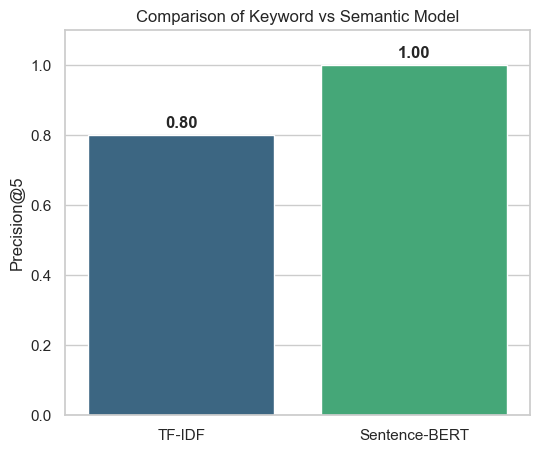

In [41]:
# Values
models = ["TF-IDF", "Sentence-BERT"]
precision_values = [precision_tfidf, precision_semantic]

# Plot
plt.figure(figsize=(6,5))
sns.barplot(x=models, y=precision_values, palette="viridis")
plt.ylim(0, 1.1)
plt.ylabel("Precision@5")
plt.title("Comparison of Keyword vs Semantic Model")
for i, v in enumerate(precision_values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()

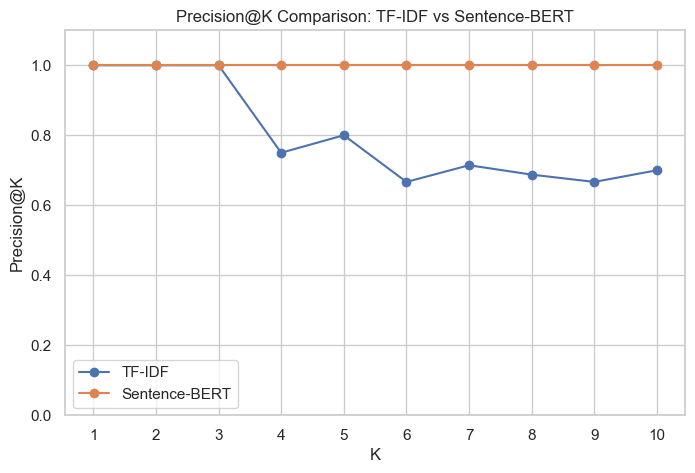

In [42]:
k_values = list(range(1, 11))
precision_tfidf_k = [precision_at_k(similarity_matrix, k=k) for k in k_values]
precision_semantic_k = [precision_at_k(semantic_similarity, k=k) for k in k_values]

plt.figure(figsize=(8,5))
plt.plot(k_values, precision_tfidf_k, marker='o', label='TF-IDF')
plt.plot(k_values, precision_semantic_k, marker='o', label='Sentence-BERT')
plt.xlabel("K")
plt.ylabel("Precision@K")
plt.title("Precision@K Comparison: TF-IDF vs Sentence-BERT")
plt.xticks(k_values)
plt.ylim(0, 1.1)
plt.legend()
plt.grid(True)
plt.show()

In [43]:
!pip install -q ipywidgets matplotlib seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [44]:
import ipywidgets as widgets
from IPython.display import display, clear_output

sns.set(style="whitegrid")

In [45]:
# Dropdown for patient selection
patient_dropdown = widgets.Dropdown(
    options=[(f"Patient {i} ({patients.iloc[i]['conditions']})", i) for i in range(len(patients))],
    description="Patient:"
)

# Dropdown for model choice
model_dropdown = widgets.Dropdown(
    options=[("TF-IDF", "tfidf"), ("Sentence-BERT", "semantic")],
    description="Model:"
)

# Slider for top K recommendations
top_k_slider = widgets.IntSlider(
    value=5,
    min=1,
    max=10,
    step=1,
    description='Top K:'
)

# Button to generate recommendations
button = widgets.Button(description="Get Recommendations")

# Output area
output = widgets.Output()

In [46]:
def get_ranked_trials(patient_idx, model_choice, top_k):
    if model_choice == "tfidf":
        return rank_trials_for_patient(patient_idx, top_k)
    else:
        return rank_trials_semantic(patient_idx, top_k)
    
def get_explanations(patient_idx, model_choice, top_k):
    return explain_top_trials(patient_idx, top_k)

In [47]:
def plot_precision_k(model_choice, max_k=10):
    k_values = list(range(1, max_k+1))
    if model_choice == "tfidf":
        precision_values = [precision_at_k(similarity_matrix, k=k) for k in k_values]
        title = "TF-IDF Precision@K"
    else:
        precision_values = [precision_at_k(semantic_similarity, k=k) for k in k_values]
        title = "Sentence-BERT Precision@K"
    
    plt.figure(figsize=(6,4))
    sns.lineplot(x=k_values, y=precision_values, marker='o')
    plt.ylim(0,1.1)
    plt.xticks(k_values)
    plt.xlabel("K")
    plt.ylabel("Precision@K")
    plt.title(title)
    for i, v in enumerate(precision_values):
        plt.text(k_values[i], v+0.02, f"{v:.2f}", ha='center', fontweight='bold')
    plt.show()

In [48]:
def on_button_click(b):
    clear_output()
    display(patient_dropdown, model_dropdown, top_k_slider, button, output)
    
    patient_idx = patient_dropdown.value
    model_choice = model_dropdown.value
    top_k = top_k_slider.value
    
    # Get recommendations and explanations
    recommendations = get_ranked_trials(patient_idx, model_choice, top_k)
    explanations = get_explanations(patient_idx, model_choice, top_k)
    
    with output:
        # Show recommendations
        print(f"\nTop {top_k} Recommendations for Patient {patient_idx} using {model_dropdown.label}:")
        display(recommendations)
        
        # Show explanations
        print("\nDetailed Explanations:")
        for i, exp in enumerate(explanations, 1):
            print(f"\nRecommendation {i}:")
            for k, v in exp.items():
                print(f"{k}: {v}")
        
        # Show Precision@K plot
        print("\nModel Precision@K:")
        plot_precision_k(model_choice, max_k=10)

In [49]:
button.on_click(on_button_click)

display(patient_dropdown, model_dropdown, top_k_slider, button, output)

Dropdown(description='Patient:', options=(('Patient 0 (covid-19)', 0), ('Patient 1 (covid-19 pneumonia)', 1)),…

Dropdown(description='Model:', options=(('TF-IDF', 'tfidf'), ('Sentence-BERT', 'semantic')), value='tfidf')

IntSlider(value=5, description='Top K:', max=10, min=1)

Button(description='Get Recommendations', style=ButtonStyle())

Output()

An NLP-driven clinical trial recommendation system that semantically matches synthetic patient profiles to trial eligibility criteria, applies eligibility rules, and provides explainable, ranked recommendations with measurable improvement over a keyword baseline.